In [1]:
buy_decision_model = 'dummy'
price_decision_model = 'dummy'
start_simulation = '2017-10-01' #YYYY-MM-DD
end_simulation = '2021-12-31' #YYYY-MM-DD
symbol = 'ETHBTC'
max_batch_size = 5000 # purely for lambda memory considerations
starting_funds = 1
# reference_coin (ETH / BTC) / reverse

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re

# models
import buy_decision
import price_decision

In [3]:
# local only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
import datetime
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

# validate symbol
assert re.match('^[A-Z]{2,}$', symbol), f"{symbol} is invalid symbol"

# validate starting funds
assert starting_funds > 0, "Starting funds for must be > 0"

# validate batch size
assert (isinstance(max_batch_size, int) and max_batch_size > 0), f"{max_batch_size} is not a valid batch size"

# validate model names too!
# TODO: validate model names

In [5]:
def get_batch_data(pair_symbol, start_time, end_time, batch_size):
    # TODO: this needs to be expanded to include engineered features
    sql = f"""
    select * from candlestick_15m cm 
    inner join pairs p on cm.pair_id = p.id 
    where
        p.symbol = '{pair_symbol}'
        and cm.close_time notnull
        and cm.open_time between '{start_time}' and '{end_time}'
    order by cm.open_time limit {batch_size}
    """
    df = pd.read_sql_query(sql, conn)
    return df

In [6]:
# initialization

buy_model = buy_decision.__dict__[buy_decision_model]
price_model = price_decision.__dict__[price_decision_model]
buy_columns = buy_model.columns()
price_columns = price_model.columns()
stop_loss_trigger = None
target_trigger = None

In [7]:
current_time = start_simulation
all_output = []

while True:
    # this batch data should also include feature engineering
    batch_data = get_batch_data(symbol, current_time, end_simulation, max_batch_size)
    
    if len(batch_data) == 0:
        break
    
    batch_buy_decision = buy_decision.__dict__[buy_decision_model].make_decision(batch_data[buy_columns].values)
    batch_price_decision = price_decision.__dict__[price_decision_model].stop_loss_target_range(batch_data[price_columns].values)

    output = batch_data[['open_time','open', 'high', 'low', 'close']].copy()
    output['buy_decision'] = batch_buy_decision
    output[['target_price', 'stop-loss_price']] = batch_price_decision
    
    all_output.append(output)
    current_time = batch_data['close_time'].max()

results = pd.concat(all_output).set_index('open_time')

In [8]:
results[['fund1','fund2','action']] = np.nan
cur_funds = [starting_funds,0]
results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
results.iloc[0, results.columns.get_loc('fund2')] = 0

for x,r in results.iterrows():
    if cur_funds[0] > 0:
        if r['buy_decision'] == True:
            cur_funds[1] = cur_funds[0] * r['close']
            cur_funds[0] = 0
            results.loc[x,'fund1'] = cur_funds[0]
            results.loc[x,'fund2'] = cur_funds[1]
            stop_loss_trigger = r['stop-loss_price']
            target_trigger = r['target_price']
            results.loc[x,'action'] = 'buy'

    else:
        if r['high'] <= target_trigger:
            cur_funds[0] = cur_funds[1] / target_trigger
            cur_funds[1] = 0
            results.loc[x,'fund1'] = cur_funds[0]
            results.loc[x,'fund2'] = cur_funds[1]
            results.loc[x,'action'] = 'sell'
        elif r['low'] >= stop_loss_trigger:
            cur_funds[0] = cur_funds[1] / stop_loss_trigger
            cur_funds[1] = 0
            results.loc[x,'fund1'] = cur_funds[0]
            results.loc[x,'fund2'] = cur_funds[1]
            results.loc[x,'action'] = 'sell'
results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
results['total_value'] = results['fund1'] + results['fund2'] / results['close']
results['action'] = results['action'].fillna('none')

Relative ETH value of portfolio


<AxesSubplot:xlabel='open_time'>

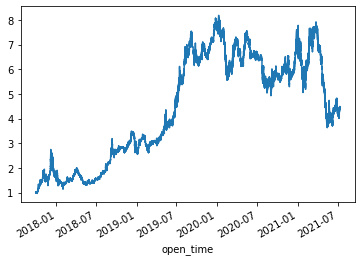

In [9]:
print("Relative ETH value of portfolio")
results.total_value.plot()

In [10]:
results[results['action']!='none']

,open,high,low,close,buy_decision,target_price,stop-loss_price,fund1,fund2,action,total_value
open_time,,,,,,,,,,,
2017-10-01 02:45:00,0.069305,0.069798,0.069200,0.069708,True,0.065840,0.072770,0.000000,0.069708,buy,1.000000
2017-10-09 03:45:00,0.065721,0.065744,0.065357,0.065546,False,0.062435,0.069007,1.058753,0.000000,sell,1.058753
2017-10-09 04:45:00,0.065407,0.066739,0.065324,0.066380,True,0.062137,0.068677,0.000000,0.070280,buy,1.058753
2017-10-09 18:45:00,0.061835,0.061851,0.061019,0.061269,False,0.058743,0.064927,1.131055,0.000000,sell,1.131055
2017-10-09 19:45:00,0.059186,0.060469,0.058810,0.060278,True,0.056227,0.062145,0.000000,0.068178,buy,1.131055
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:45:00,0.064239,0.064631,0.064121,0.064562,True,0.061027,0.067451,0.000000,0.272425,buy,4.219587
2021-07-06 12:15:00,0.067865,0.068219,0.067744,0.067846,False,0.064472,0.071258,4.038861,0.000000,sell,4.038861
2021-07-07 04:15:00,0.067849,0.068770,0.067735,0.068710,True,0.064457,0.071241,0.000000,0.277510,buy,4.038861
